In [72]:
import numpy as np
import pandas as pd 
import os 
import json
from pandas.io.json import json_normalize
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

Import Sagemaker modules
* sagemaker_session: The SageMaker session we'll use for training models.
* bucket: The name of the default S3 bucket that we'll use for data storage.
* role: The IAM role that defines our data and model permissions.

In [6]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

session = sagemaker.Session()
role = get_execution_role()

# S3 bucket name
bucket = session.default_bucket()

In [6]:
bucket

'sagemaker-us-east-1-260679286230'

## Step 1: Load and Explore Data 

The dataset is downloaded from Kaggle

In [1]:
! cat data/train_clean.csv | wc -l

903654


In [9]:
train = pd.read_csv('data/train_clean.csv')
test = pd.read_csv('data/test_clean.csv')

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
train.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,...,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1472830385,1,1472830385,Chrome,desktop,False,Windows,...,1.0,1.0,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,1472880147,1,1472880147,Firefox,desktop,False,Macintosh,...,1.0,1.0,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,1472865386,1,1472865386,Chrome,desktop,False,Windows,...,1.0,1.0,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,1472881213,1,1472881213,UC Browser,desktop,False,Linux,...,1.0,1.0,NaN,NaN,(not set),NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,1472822600,2,1472822600,Chrome,mobile,True,Android,...,NaN,1.0,NaN,NaN,(not set),True,(not provided),organic,NaN,google


In [21]:
train.dtypes

channelGrouping                object
date                            int64
fullVisitorId                  object
visitId                         int64
visitNumber                     int64
visitStartTime                  int64
device.browser                 object
device.deviceCategory          object
device.isMobile                  bool
device.operatingSystem         object
geoNetwork.city                object
geoNetwork.continent           object
geoNetwork.country             object
geoNetwork.metro               object
geoNetwork.networkDomain       object
geoNetwork.region              object
geoNetwork.subContinent        object
totals.bounces                float64
totals.hits                     int64
totals.newVisits              float64
totals.pageviews              float64
totals.transactionRevenue     float64
trafficSource.adContent        object
trafficSource.campaign         object
trafficSource.isTrueDirect     object
trafficSource.keyword          object
trafficSourc

1. Explore the outcome: natural log of sum of all transactions

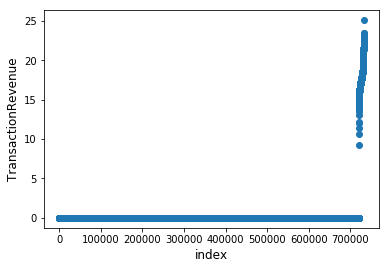

In [5]:
gdf = train.groupby('fullVisitorId').agg({'totals.transactionRevenue':'sum'}).reset_index()

plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize = 12)
plt.ylabel('TransactionRevenue', fontsize = 12)
plt.show()

As shown in the graph, a small proportion of the customers produce most of the revenue. These are the most valuable customers which we need to identity their identities, behavior patterns and act accordingly

In [6]:
print('percent of non-zero transactions: {}'.format(
    str(pd.notnull(train["totals.transactionRevenue"]).sum()/train.shape[0])))
print('percent of customers with non-zero revenues: {}'.format(
    str((gdf["totals.transactionRevenue"]>0).sum()/gdf.shape[0])))

percent of non-zero transactions: 0.0127427231470487
percent of customers with non-zero revenues: 0.013976902495279737


Of all the customers visit the google store from 2016-08-01 to 2017-08-01, only 1.4% of the vistors are actually revenue generated customers. 

2. Explore Device Information

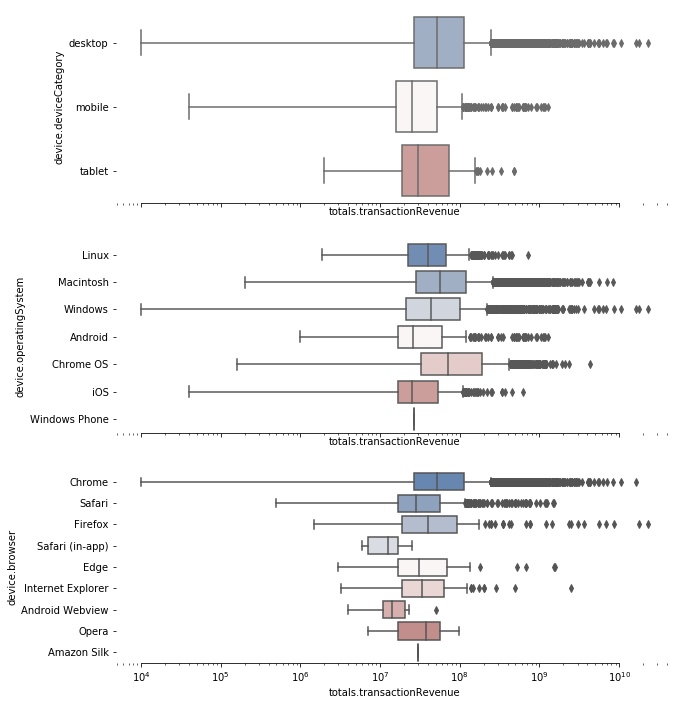

In [91]:
f, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (10,12), sharex = True)

sns.boxplot(x = "totals.transactionRevenue", y = "device.deviceCategory", data = train, palette="vlag", ax = ax[0])
ax[0].set_xscale("log")
sns.boxplot(x = "totals.transactionRevenue", y = "device.operatingSystem", 
            data = train.loc[train["totals.transactionRevenue"] > 0], palette="vlag", ax = ax[1])
ax[1].set_xscale("log")

sns.boxplot(x = "totals.transactionRevenue", y = "device.browser", 
            data = train.loc[train["totals.transactionRevenue"] > 0], palette="vlag", ax = ax[2])
ax[2].set_xscale("log")
sns.despine(trim=True, left=True)

3. Explore PageViews

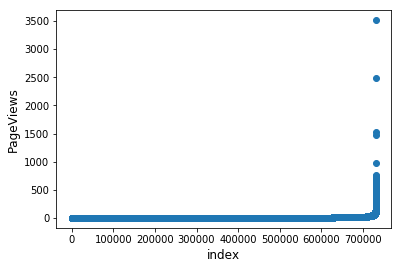

In [93]:
df_pv = train.groupby('fullVisitorId').agg({'totals.pageviews':'sum'}).reset_index()

plt.scatter(range(df_pv.shape[0]), np.sort(df_pv["totals.pageviews"].values))
plt.xlabel('index', fontsize = 12)
plt.ylabel('PageViews', fontsize = 12)
plt.show()

Page views show a similar pattern as our outcome-- the transactions data. It will be a good indirect indicator for our outcome data.

## Step 2: Feature Engineering

In this part, I created customer segmentations using RFM.
**RFM** stands for Recency- Frequency - Monetary Value.

The segments include:

* Low Value: Customers who are less active than others, not very frequent buyer/visitor and generate very low-zero-maybe negative revenue.
* Mid Value: Customers who are using the Google platform farily frequent and generate moderate revenue.
* High Value: High revenue, frequency and low inactivity.

### Recency
* to find out most recent purchase date of each customer by 2017-08-01

In [126]:
train_pos = train.loc[pd.notnull(train['totals.transactionRevenue'])]

In [127]:
# create a generic user dataframe to keep customerid and new segmentation scores 
tx_user = pd.DataFrame(train_pos.fullVisitorId.unique())
tx_user.columns = ['fullVisitorId']

In [128]:
# get the max purchase date for each customers
tx_max_purchase = train_pos.groupby('fullVisitorId')['date'].max().reset_index()

In [129]:
tx_max_purchase['date'] = pd.to_datetime(tx_max_purchase['date'],format = "%Y%m%d")
tx_max_purchase['recency'] = (tx_max_purchase['date'].max() - tx_max_purchase['date']).dt.days

In [130]:
tx_user = pd.merge(tx_user, tx_max_purchase[['fullVisitorId', 'recency']], on = 'fullVisitorId')

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


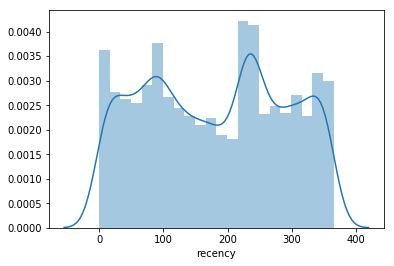

In [86]:
sns.distplot(tx_user['recency'])

In [87]:
tx_user.recency.describe()

count    10223.000000
mean       180.547882
std        108.189774
min          0.000000
25%         85.000000
50%        183.000000
75%        271.000000
max        365.000000
Name: recency, dtype: float64

From the graph and stats above, we see that the average is 180 day recency, median is 271. The graph shows a spike in purchases around 2016-12-24 (recency = 220 days) to 2017-01-13 (recency = 200 days), which could be caused by the holiday season.

In [94]:
datetime.strptime('2017-08-01', '%Y-%m-%d') - timedelta(200)

datetime.datetime(2017, 1, 13, 0, 0)

In [114]:
def find_num_clusters(feature):
    
    df = tx_user[[feature]]
    for k in range(1,10):
        kmeans = KMeans(n_clusters = k, max_iter = 1000).fit(df)
    #     tx_recency['cluster'] = kmeans.labels_
        sse[k] = kmeans.inertia_
    
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.show()

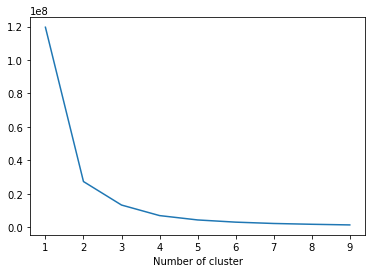

In [115]:
find_num_clusters('recency')

Based on the graph above, 3 or 4 clusters are the optimal ones. I will select 4 cluster here

In [131]:
# build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['recency']])
tx_user['recency_cluster'] = kmeans.predict(tx_user[['recency']])

## Save model for test as well
filename = "feature_models/kmeans_recency.sav"
pickle.dump(kmeans, open(filename, 'wb')) #write bytes

In [132]:
tx_user.groupby('recency_cluster').agg({'recency':['min','max','mean']})

recency                 
                    min  max        mean
recency_cluster                         
0                     0   81   38.606211
1                   178  276  229.949309
2                    82  177  124.496078
3                   277  365  322.673369

In [98]:
kmeans.inertia_

6870052.188027818

### Frequency 
* to find total number orders for each customer

In [133]:
tx_freq = train_pos.groupby('fullVisitorId').agg({'visitId':'count'}).reset_index()
tx_freq.rename(columns={'visitId': 'freq'},inplace= True)
tx_user = pd.merge(tx_user, tx_freq[['fullVisitorId', 'freq']], on = 'fullVisitorId')

In [111]:
tx_user.head()

,fullVisitorId,recency,recency_cluster,freq
0,6194193421514403509,333,1,1
1,5327166854580374902,333,1,1
2,8885051388942907862,333,1,3
3,185467632009737931,333,1,1
4,3244885836845029978,329,1,3


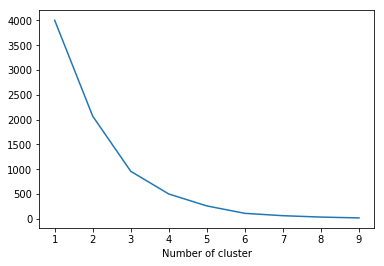

In [134]:
find_num_clusters('freq')

Based on the graph above, 4 or 5 clusters are the optimal ones. I will select 5 cluster here

In [135]:
# build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=5)
kmeans.fit(tx_user[['freq']])
tx_user['freq_cluster'] = kmeans.predict(tx_user[['freq']])

## Save model for test as well
filename = "feature_models/kmeans_freq.sav"
pickle.dump(kmeans, open(filename, 'wb')) #write bytes

In [136]:
tx_user.groupby('freq_cluster').agg({'freq':['min','max','mean']})

freq               
              min max       mean
freq_cluster                    
0               8  16  10.461538
1               1   1   1.000000
2               2   3   2.179790
3              29  29  29.000000
4               4   7   4.723077

### Monetary

In [137]:
tx_pv = train_pos.groupby('fullVisitorId').agg({'totals.pageviews':'sum'}).reset_index()
tx_pv.rename(columns={'totals.pageviews': 'pageviews'},inplace= True)
tx_user = pd.merge(tx_user, tx_pv[['fullVisitorId', 'pageviews']], on = 'fullVisitorId')

KeyError: "['pagevies'] not in index"

In [140]:
tx_user.pageviews.describe()

count    10223.000000
mean        31.910887
std         31.939338
min          2.000000
25%         17.000000
50%         24.000000
75%         37.000000
max        671.000000
Name: pageviews, dtype: float64

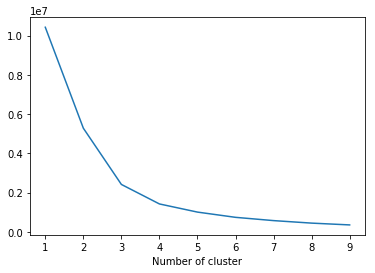

In [141]:
find_num_clusters('pageviews')

In [142]:
# build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['pageviews']])
tx_user['pv_cluster'] = kmeans.predict(tx_user[['pageviews']])

## Save model for test as well
filename = "feature_models/kmeans_pv.sav"
pickle.dump(kmeans, open(filename, 'wb')) #write bytes

In [ ]:
tx_user.groupby('pv_cluster').agg({'pagev':['min','max','mean']})

In [ ]:

# def engineer_features(user_df, df, model_file, col_name):
#    mod1 = pickle.load(open(model_file, 'rb'))
#    user_df[col_name+"_cluster"] = mod1.predict(user_df[col_name])
#    df = pd.merge(df, user_df[['fullVisitorId']])